# CAB420, DCNNs, Additional Script: Lots of VGG-Like Models
Dr Simon Denman (s.denman@qut.edu.au)

## What is this all about?

This is a script that will train, and save, a bunch of models on the datasets that we use most commonly in CAB420. A mix of models, all based around a VGG style, will be trained.

These will all utilise the a couple of functions to build the network for us, which has been inspired by the ResNet example. Basically, it made sense to do the same thing for VGG networks as was done for ResNet.

As per the ResNet example, results are shown for each model, but this is really just about training models for use later on. Networks of different levels of complexity (i.e. number of layers, numbers of filters) are trained to enable comparisson, but also to allow students to pick a network that suits the computational budget they have (i.e. if you have an old laptop, use a simpler model; if you have a GPU, you might want to use something bigger).

As per the ResNet exmaples, this was run on a GPU equipped desktop.

In [1]:
import os
import datetime
import numpy

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint

## Network Building Functions
We'll set up a function or three to build the networks for us. We'll have:
* A function to build a convolution block. This is two 2D convolutions, each with 3x3 kernels and the same number of filters, followed by BatchNormalisation and optionally a spatial dropout and 2x2 max-pooling. We'll use this such that we always have a max-pool unless it's the last block
* A function to build a fully connected block. This will have a fully connected layer of specified size, a batch-norm, and then optionally dropout
* A function to build the network as a whole. This will take in an input layer, the list of filters sizes for the convolution blocks, list of fully connected layer sizes, spatial dropout rate, and dropout rate. This won't create an input or an output - that up to you when you call it.

In [2]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

## Model Training, Evaluation and Saving
Simple function to:
* Create a checkpoint to save the best weights
* Train the network
* Load the best model weights
* Save the whole model, architeture and best weights
* Plot the loss and accuracy grapsh
* Evaluate the best model on the training and testing sets

In [3]:
def train_and_eval(model, x_train, y_train, x_test, y_test, filename, batch_size, epochs):
    
    checkpoint = ModelCheckpoint(filename, verbose=1, monitor='val_loss',save_best_only=True, mode='auto')
    
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[checkpoint])    
    
    model.load_weights(filename)
    model.save(filename)    
    
    fig = plt.figure(figsize=[30, 10])
    ax = fig.add_subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    ax.legend()
    ax.set_title('Training Performance')

    
    ax = fig.add_subplot(1, 3, 2)
    pred = model.predict(x_train);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_train, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Training')
    
    ax = fig.add_subplot(1, 3, 3)
    pred = model.predict(x_test);
    indexes = tf.argmax(pred, axis=1)
    cm = confusion_matrix(y_test, indexes)
    c = ConfusionMatrixDisplay(cm, display_labels=range(10))
    c.plot(ax = ax)    
    ax.set_title('Testing')

## Some Global Constants
These are some constant values that we'll use in these models. Things like the batch size and number of epochs.

In [4]:
batch_size = 128;
num_epochs = 10;

## Fashion MNIST Models

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### VGG, 2 Stage, Small

2022-01-11 03:38:12.008225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-01-11 03:38:12.348352: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6177 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5


Epoch 1/10


2022-01-11 03:38:13.908140: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301


  1/469 [..............................] - ETA: 14:38 - loss: 2.7701 - accuracy: 0.1016

2022-01-11 03:38:14.340797: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-11 03:38:14.341146: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-11 03:38:14.341175: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-01-11 03:38:14.341456: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-01-11 03:38:14.341494: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


469/469 [==============================] - ETA: 0s - loss: 0.4363 - accuracy: 0.8442
Epoch 00001: val_loss improved from inf to 0.36655, saving model to vgg_2stage_FashionMNIST_small.h5
469/469 [==============================] - 5s 6ms/step - loss: 0.4363 - accuracy: 0.8442 - val_loss: 0.3665 - val_accuracy: 0.8620
Epoch 2/10
465/469 [============================>.] - ETA: 0s - loss: 0.2998 - accuracy: 0.8901
Epoch 00002: val_loss improved from 0.36655 to 0.27190, saving model to vgg_2stage_FashionMNIST_small.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.2997 - accuracy: 0.8900 - val_loss: 0.2719 - val_accuracy: 0.9010
Epoch 3/10
468/469 [============================>.] - ETA: 0s - loss: 0.2600 - accuracy: 0.9053
Epoch 00003: val_loss did not improve from 0.27190
469/469 [==============================] - 4s 8ms/step - loss: 0.2599 - accuracy: 0.9053 - val_loss: 0.2744 - val_accuracy: 0.8999
Epoch 4/10
469/469 [==============================] - ETA: 0s - loss: 0.2

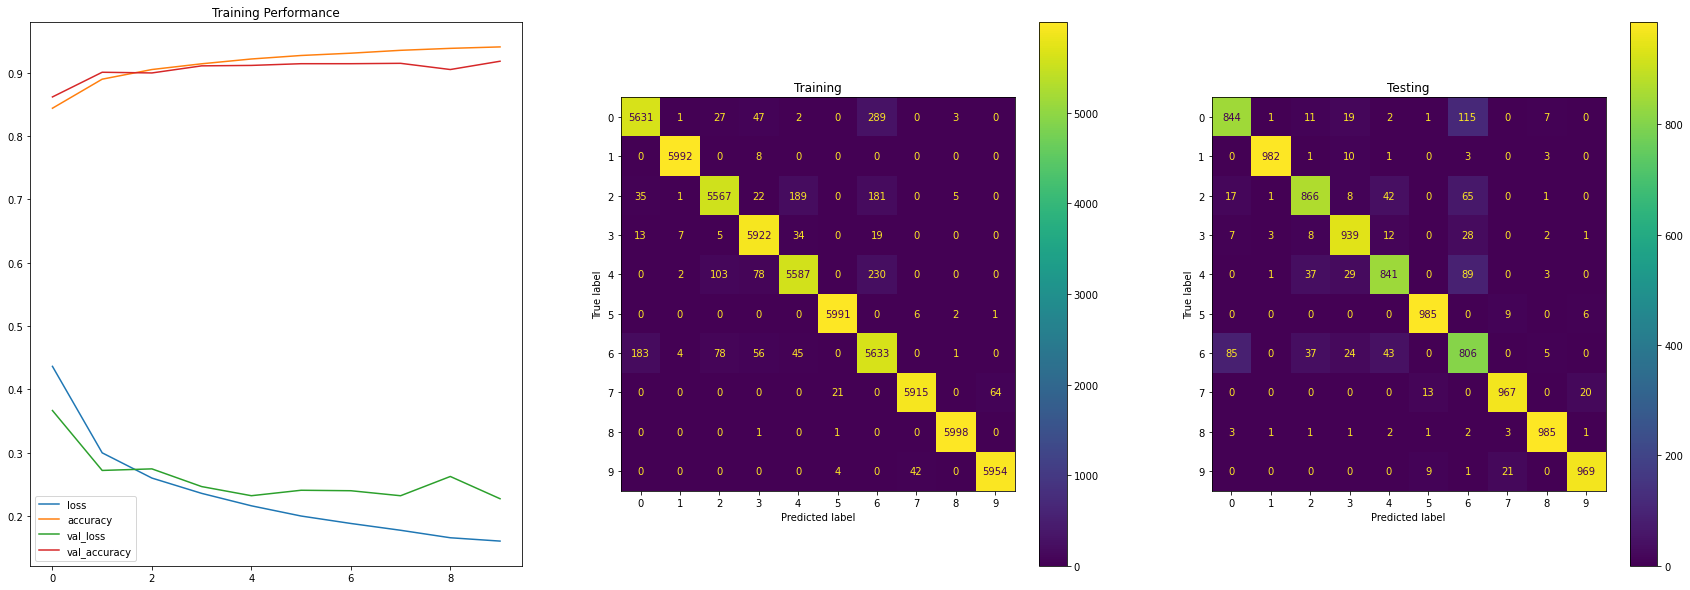

In [6]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_FashionMNIST_small.h5', batch_size, num_epochs)

### VGG, 2 Stage, Bigger

Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.4207 - accuracy: 0.8467
Epoch 00001: val_loss improved from inf to 0.36026, saving model to vgg_2stage_FashionMNIST_bigger.h5
469/469 [==============================] - 6s 10ms/step - loss: 0.4207 - accuracy: 0.8467 - val_loss: 0.3603 - val_accuracy: 0.8654
Epoch 2/10
465/469 [============================>.] - ETA: 0s - loss: 0.2770 - accuracy: 0.8989
Epoch 00002: val_loss improved from 0.36026 to 0.28896, saving model to vgg_2stage_FashionMNIST_bigger.h5
469/469 [==============================] - 4s 9ms/step - loss: 0.2768 - accuracy: 0.8989 - val_loss: 0.2890 - val_accuracy: 0.9024
Epoch 3/10
468/469 [============================>.] - ETA: 0s - loss: 0.2320 - accuracy: 0.9141
Epoch 00003: val_loss improved from 0.28896 to 0.28488, saving model to vgg_2stage_FashionMNIST_bigger.h5
469/469 [==============================] - 5s 10ms/step - loss: 0.2319 - accuracy: 0.9141 - val_loss: 0.2849 - val_accuracy: 0.9064
Epo

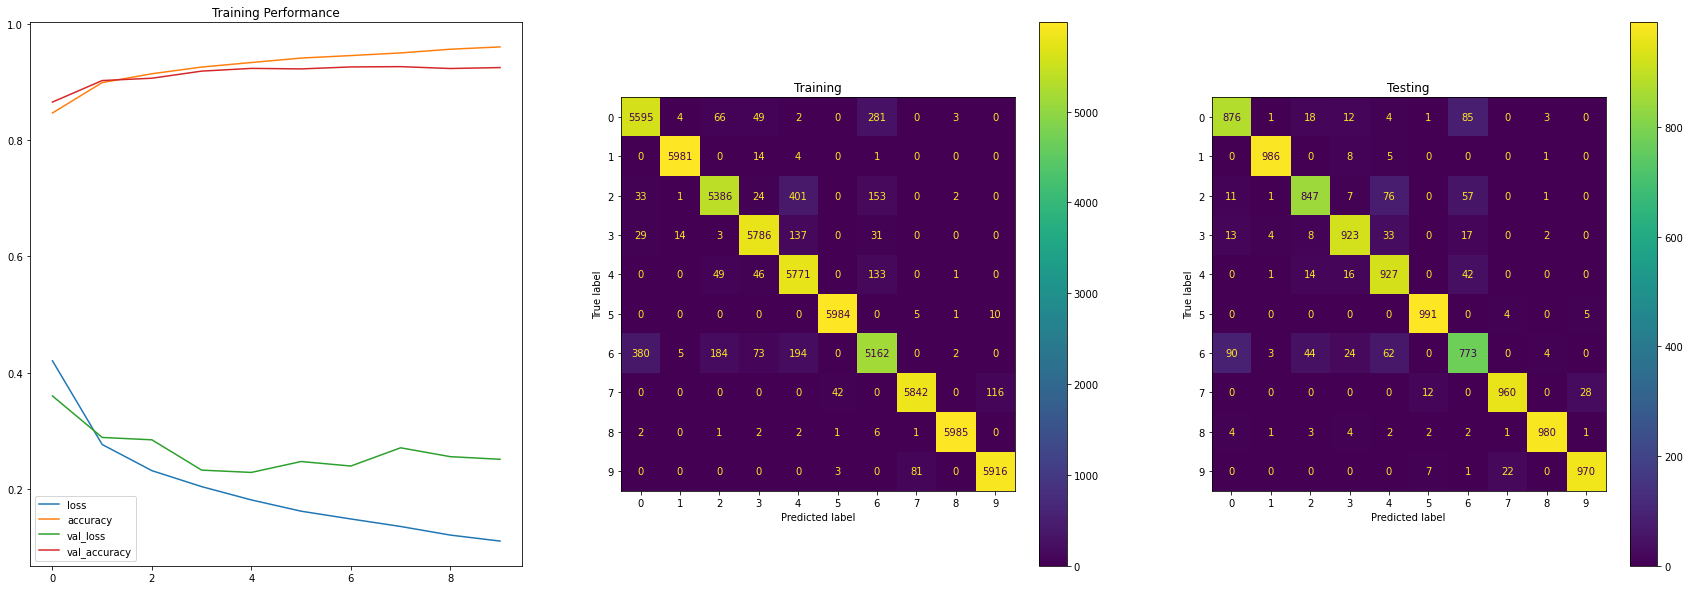

In [7]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_FashionMNIST_bigger.h5', batch_size, num_epochs)

### VGG, 3 Stage, Small

Epoch 1/10
469/469 [==============================] - ETA: 0s - loss: 0.5229 - accuracy: 0.8069
Epoch 00001: val_loss improved from inf to 0.45895, saving model to vgg_3stage_FashionMNIST_small.h5
469/469 [==============================] - 6s 11ms/step - loss: 0.5229 - accuracy: 0.8069 - val_loss: 0.4590 - val_accuracy: 0.8349
Epoch 2/10
467/469 [============================>.] - ETA: 0s - loss: 0.3505 - accuracy: 0.8702
Epoch 00002: val_loss improved from 0.45895 to 0.33873, saving model to vgg_3stage_FashionMNIST_small.h5
469/469 [==============================] - 4s 10ms/step - loss: 0.3505 - accuracy: 0.8702 - val_loss: 0.3387 - val_accuracy: 0.8820
Epoch 3/10
463/469 [============================>.] - ETA: 0s - loss: 0.3095 - accuracy: 0.8843
Epoch 00003: val_loss improved from 0.33873 to 0.27945, saving model to vgg_3stage_FashionMNIST_small.h5
469/469 [==============================] - 5s 10ms/step - loss: 0.3091 - accuracy: 0.8845 - val_loss: 0.2795 - val_accuracy: 0.8979
Epoch

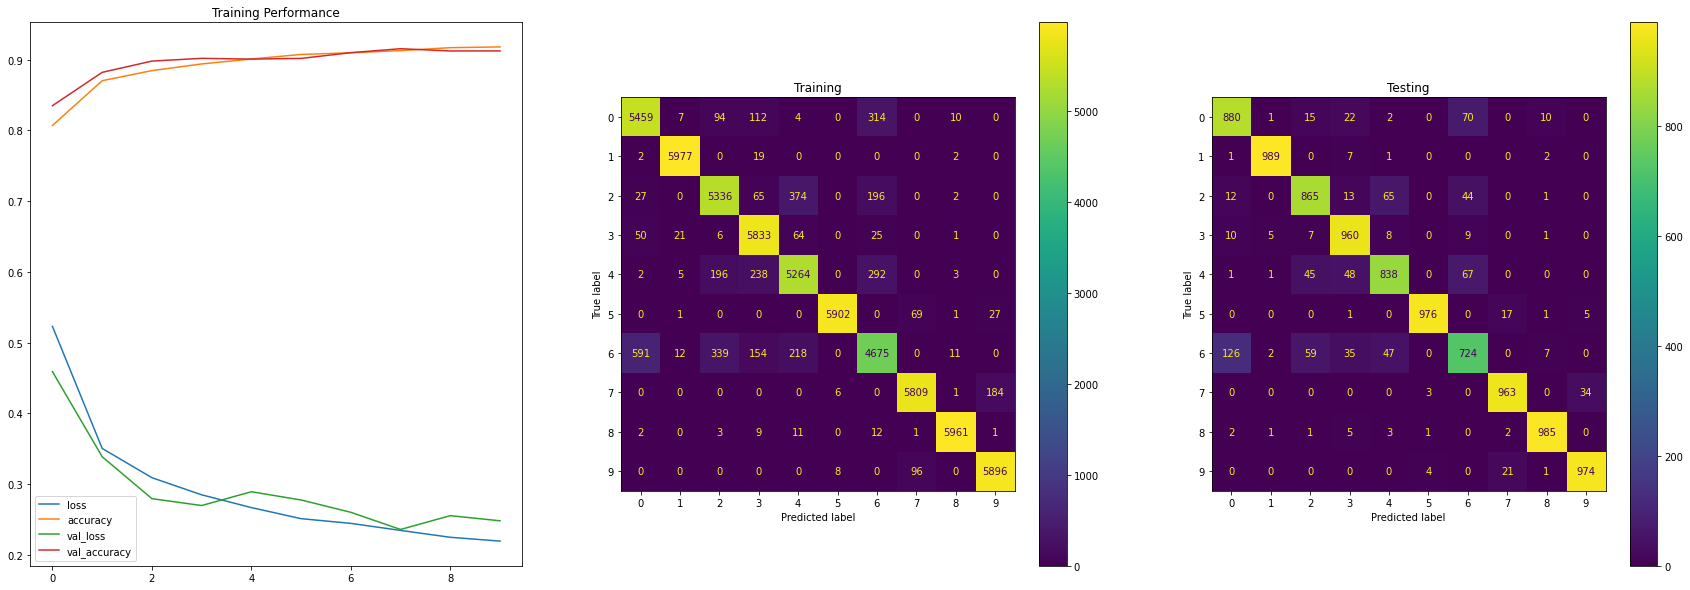

In [8]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_3stage_FashionMNIST_small.h5', batch_size, num_epochs)

### VGG, 3 Stage, Bigger

Epoch 1/10
468/469 [============================>.] - ETA: 0s - loss: 0.4518 - accuracy: 0.8330
Epoch 00001: val_loss improved from inf to 0.35837, saving model to vgg_3stage_FashionMNIST_bigger.h5
469/469 [==============================] - 6s 10ms/step - loss: 0.4518 - accuracy: 0.8330 - val_loss: 0.3584 - val_accuracy: 0.8774
Epoch 2/10
469/469 [==============================] - ETA: 0s - loss: 0.2987 - accuracy: 0.8907
Epoch 00002: val_loss improved from 0.35837 to 0.28876, saving model to vgg_3stage_FashionMNIST_bigger.h5
469/469 [==============================] - 4s 9ms/step - loss: 0.2987 - accuracy: 0.8907 - val_loss: 0.2888 - val_accuracy: 0.8957
Epoch 3/10
468/469 [============================>.] - ETA: 0s - loss: 0.2606 - accuracy: 0.9038
Epoch 00003: val_loss improved from 0.28876 to 0.27204, saving model to vgg_3stage_FashionMNIST_bigger.h5
469/469 [==============================] - 4s 9ms/step - loss: 0.2607 - accuracy: 0.9038 - val_loss: 0.2720 - val_accuracy: 0.9053
Epoc

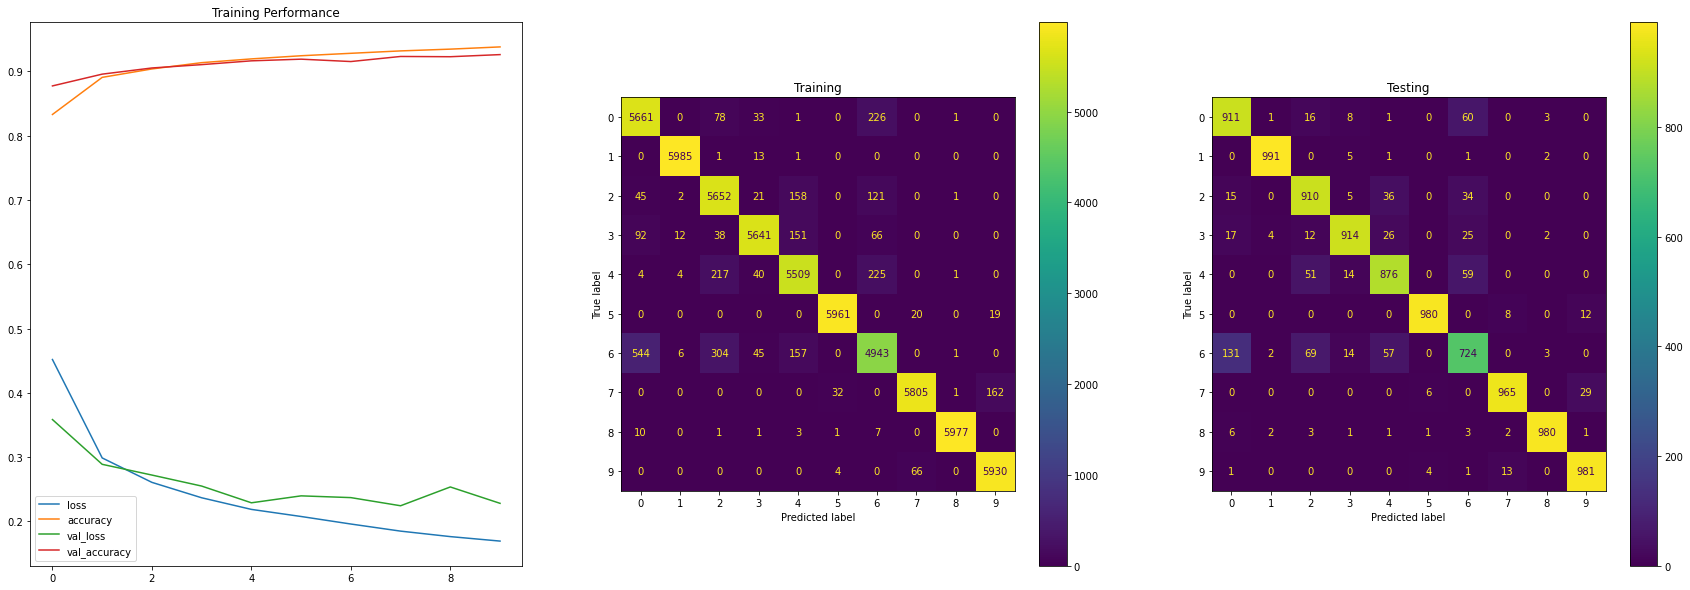

In [9]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32, 64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_3stage_FashionMNIST_bigger.h5', batch_size, num_epochs)

## MNIST Models

In [10]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### VGG, 2 Stage, Small

Epoch 1/10
464/469 [============================>.] - ETA: 0s - loss: 0.1718 - accuracy: 0.9476
Epoch 00001: val_loss improved from inf to 0.06880, saving model to vgg_2stage_MNIST_small.h5
469/469 [==============================] - 5s 9ms/step - loss: 0.1711 - accuracy: 0.9478 - val_loss: 0.0688 - val_accuracy: 0.9791
Epoch 2/10
467/469 [============================>.] - ETA: 0s - loss: 0.0695 - accuracy: 0.9787
Epoch 00002: val_loss improved from 0.06880 to 0.04922, saving model to vgg_2stage_MNIST_small.h5
469/469 [==============================] - 4s 7ms/step - loss: 0.0696 - accuracy: 0.9786 - val_loss: 0.0492 - val_accuracy: 0.9836
Epoch 3/10
468/469 [============================>.] - ETA: 0s - loss: 0.0526 - accuracy: 0.9839
Epoch 00003: val_loss improved from 0.04922 to 0.02866, saving model to vgg_2stage_MNIST_small.h5
469/469 [==============================] - 3s 7ms/step - loss: 0.0525 - accuracy: 0.9839 - val_loss: 0.0287 - val_accuracy: 0.9900
Epoch 4/10
468/469 [=========

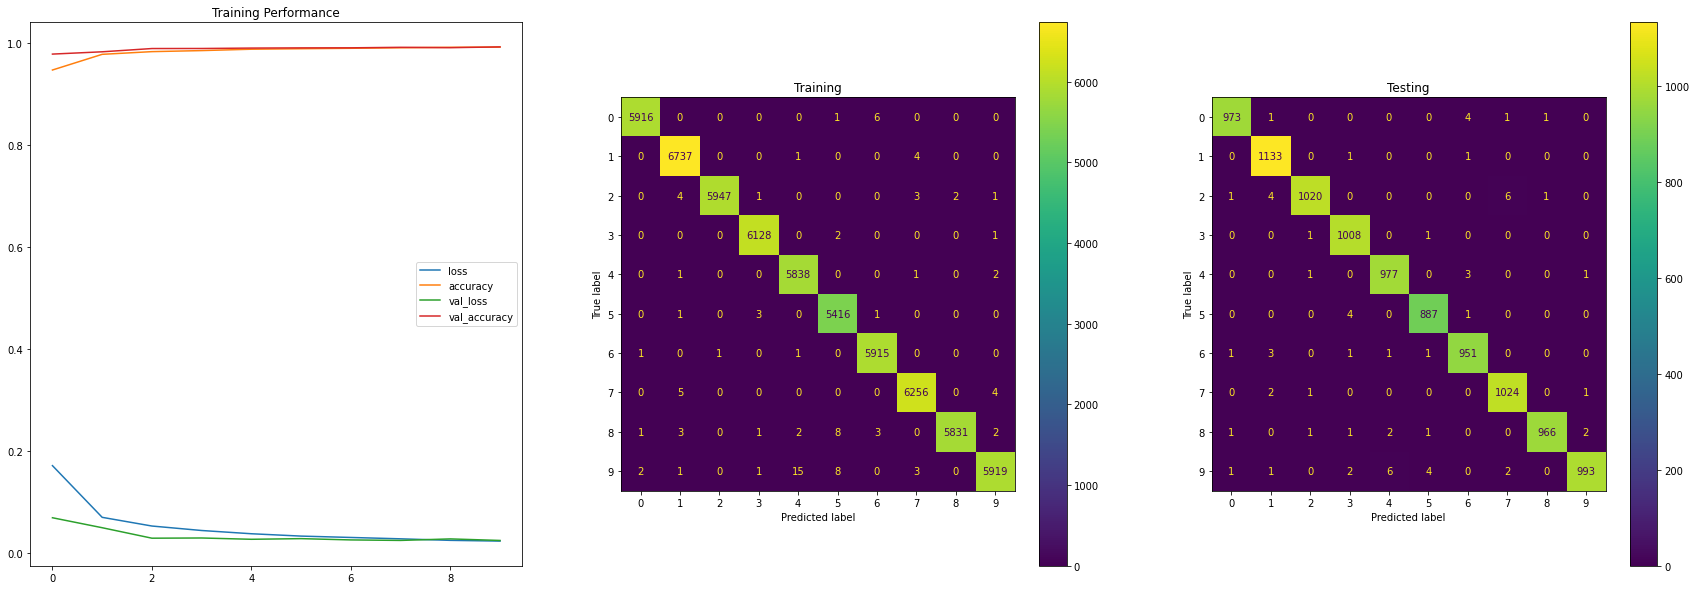

In [11]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_MNIST_small.h5', batch_size, num_epochs)

### VGG, 2 Stage, Bigger

Epoch 1/10
464/469 [============================>.] - ETA: 0s - loss: 0.1443 - accuracy: 0.9553
Epoch 00001: val_loss improved from inf to 0.04509, saving model to vgg_2stage_MNIST_bigger.h5
469/469 [==============================] - 6s 10ms/step - loss: 0.1436 - accuracy: 0.9556 - val_loss: 0.0451 - val_accuracy: 0.9866
Epoch 2/10
466/469 [============================>.] - ETA: 0s - loss: 0.0581 - accuracy: 0.9819
Epoch 00002: val_loss improved from 0.04509 to 0.03162, saving model to vgg_2stage_MNIST_bigger.h5
469/469 [==============================] - 4s 9ms/step - loss: 0.0579 - accuracy: 0.9819 - val_loss: 0.0316 - val_accuracy: 0.9901
Epoch 3/10
464/469 [============================>.] - ETA: 0s - loss: 0.0434 - accuracy: 0.9872
Epoch 00003: val_loss did not improve from 0.03162
469/469 [==============================] - 4s 9ms/step - loss: 0.0437 - accuracy: 0.9872 - val_loss: 0.0370 - val_accuracy: 0.9901
Epoch 4/10
468/469 [============================>.] - ETA: 0s - loss: 0.0

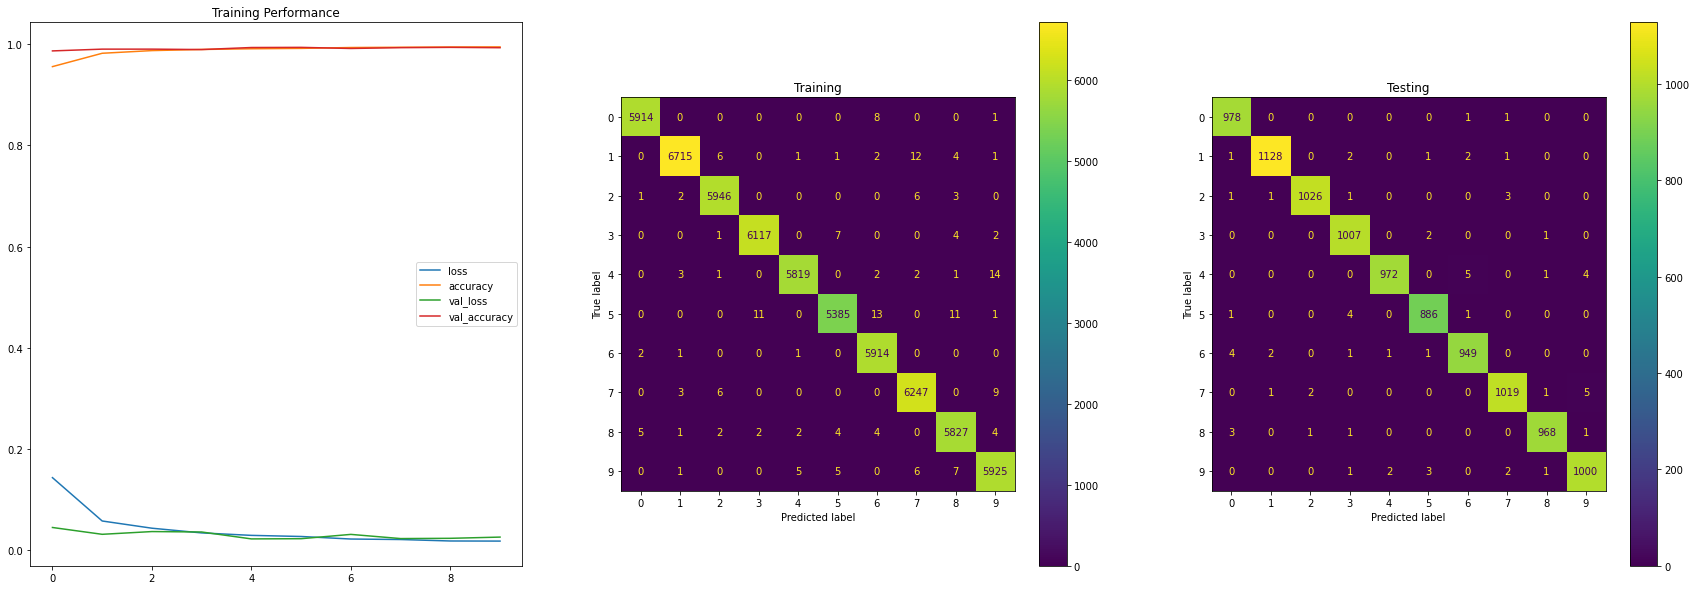

In [12]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_MNIST_bigger.h5', batch_size, num_epochs)

### VGG, 3 Stage, Small

Epoch 1/10
464/469 [============================>.] - ETA: 0s - loss: 0.2292 - accuracy: 0.9282
Epoch 00001: val_loss improved from inf to 0.05475, saving model to vgg_3stage_MNIST_small.h5
469/469 [==============================] - 5s 9ms/step - loss: 0.2275 - accuracy: 0.9288 - val_loss: 0.0547 - val_accuracy: 0.9820
Epoch 2/10
464/469 [============================>.] - ETA: 0s - loss: 0.0855 - accuracy: 0.9737
Epoch 00002: val_loss improved from 0.05475 to 0.04755, saving model to vgg_3stage_MNIST_small.h5
469/469 [==============================] - 4s 8ms/step - loss: 0.0857 - accuracy: 0.9736 - val_loss: 0.0475 - val_accuracy: 0.9871
Epoch 3/10
466/469 [============================>.] - ETA: 0s - loss: 0.0657 - accuracy: 0.9799
Epoch 00003: val_loss improved from 0.04755 to 0.03387, saving model to vgg_3stage_MNIST_small.h5
469/469 [==============================] - 4s 8ms/step - loss: 0.0656 - accuracy: 0.9799 - val_loss: 0.0339 - val_accuracy: 0.9884
Epoch 4/10
466/469 [=========

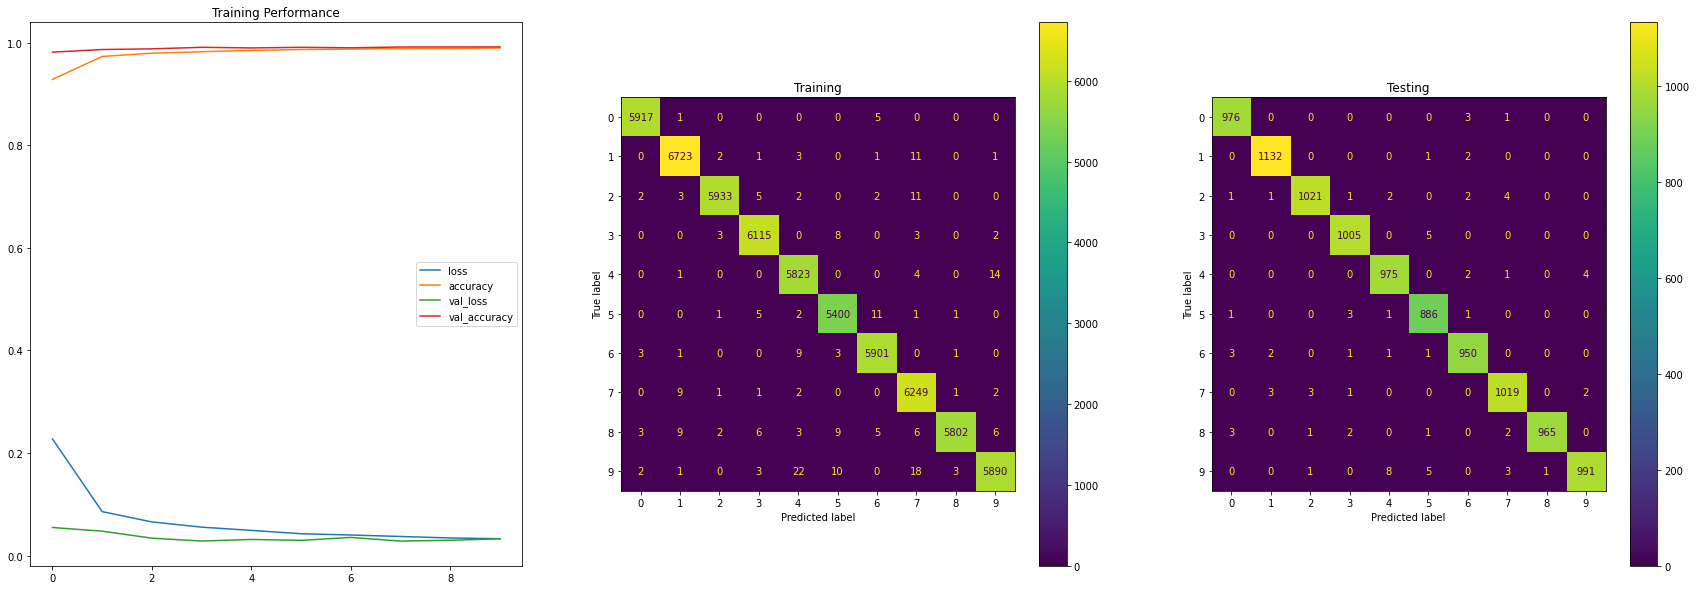

In [13]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [8, 16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_3stage_MNIST_small.h5', batch_size, num_epochs)

### VGG, 3 Stage, Bigger

Epoch 1/10
464/469 [============================>.] - ETA: 0s - loss: 0.1631 - accuracy: 0.9480
Epoch 00001: val_loss improved from inf to 0.04731, saving model to vgg_3stage_MNIST_bigger.h5
469/469 [==============================] - 6s 10ms/step - loss: 0.1624 - accuracy: 0.9483 - val_loss: 0.0473 - val_accuracy: 0.9838
Epoch 2/10
464/469 [============================>.] - ETA: 0s - loss: 0.0623 - accuracy: 0.9809
Epoch 00002: val_loss improved from 0.04731 to 0.03799, saving model to vgg_3stage_MNIST_bigger.h5
469/469 [==============================] - 4s 9ms/step - loss: 0.0619 - accuracy: 0.9810 - val_loss: 0.0380 - val_accuracy: 0.9886
Epoch 3/10
467/469 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9861
Epoch 00003: val_loss improved from 0.03799 to 0.02968, saving model to vgg_3stage_MNIST_bigger.h5
469/469 [==============================] - 5s 10ms/step - loss: 0.0459 - accuracy: 0.9862 - val_loss: 0.0297 - val_accuracy: 0.9914
Epoch 4/10
468/469 [====

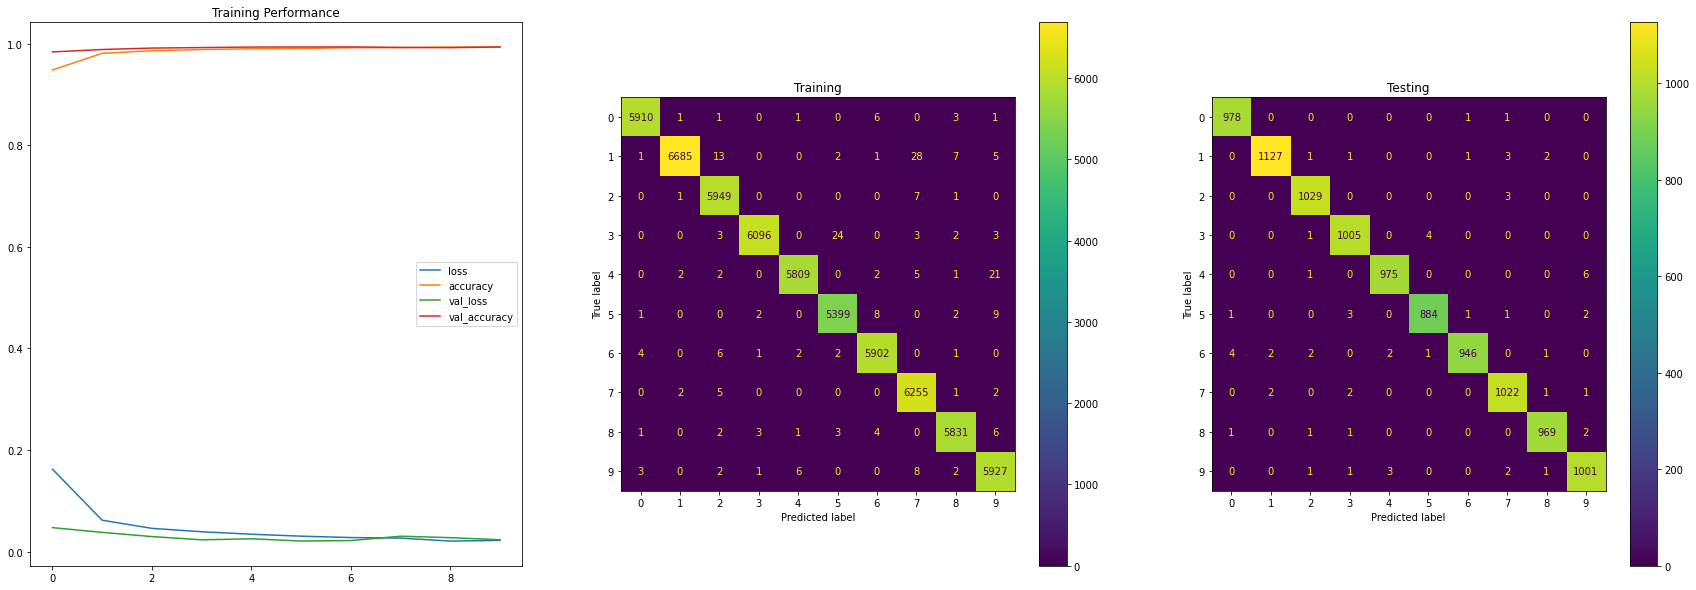

In [14]:
inputs = keras.Input(shape=(28, 28, 1, ), name='img')
x = vgg_net(inputs, [16, 32, 64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_3stage_MNIST_bigger.h5', batch_size, num_epochs)

## CIFAR-10 Models

In [15]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.reshape(x_train.shape[0], 32, 32, 3) / 255.0
y_train = y_train.reshape(y_train.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 32, 32, 3) / 255.0
y_test = y_test.reshape(y_test.shape[0], 1)

### VGG, 2 Stage, Small

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 1.6319 - accuracy: 0.4154
Epoch 00001: val_loss improved from inf to 2.13949, saving model to vgg_2stage_CIFAR_small.h5
391/391 [==============================] - 4s 8ms/step - loss: 1.6319 - accuracy: 0.4154 - val_loss: 2.1395 - val_accuracy: 0.2250
Epoch 2/10
387/391 [============================>.] - ETA: 0s - loss: 1.3064 - accuracy: 0.5327
Epoch 00002: val_loss improved from 2.13949 to 1.14145, saving model to vgg_2stage_CIFAR_small.h5
391/391 [==============================] - 3s 8ms/step - loss: 1.3054 - accuracy: 0.5332 - val_loss: 1.1414 - val_accuracy: 0.5874
Epoch 3/10
388/391 [============================>.] - ETA: 0s - loss: 1.1781 - accuracy: 0.5816
Epoch 00003: val_loss improved from 1.14145 to 1.10549, saving model to vgg_2stage_CIFAR_small.h5
391/391 [==============================] - 3s 9ms/step - loss: 1.1777 - accuracy: 0.5817 - val_loss: 1.1055 - val_accuracy: 0.6063
Epoch 4/10
390/391 [=========

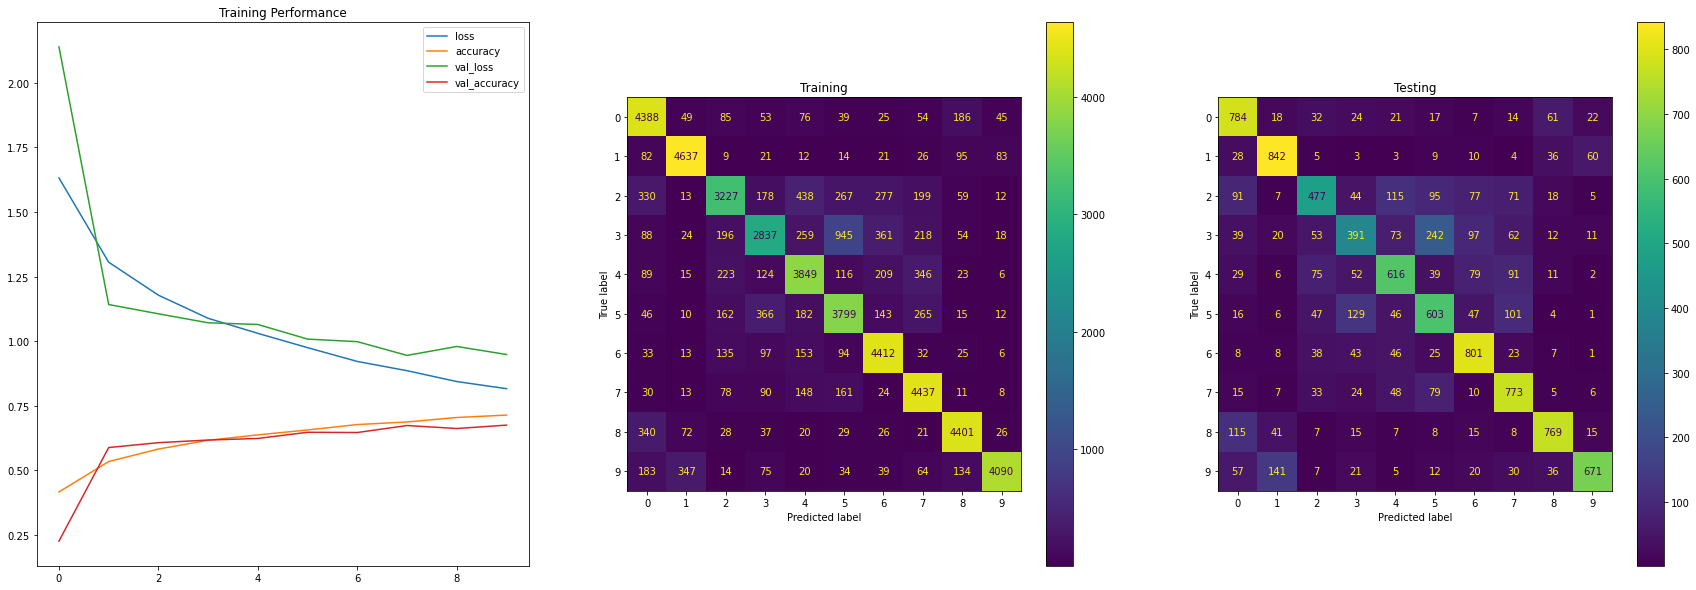

In [16]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [8, 16], [256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_CIFAR_small.h5', batch_size, num_epochs)

### VGG, 2 Stage, Bigger

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 1.5255 - accuracy: 0.4579
Epoch 00001: val_loss improved from inf to 1.52379, saving model to vgg_2stage_CIFAR_bigger.h5
391/391 [==============================] - 5s 11ms/step - loss: 1.5255 - accuracy: 0.4579 - val_loss: 1.5238 - val_accuracy: 0.4445
Epoch 2/10
389/391 [============================>.] - ETA: 0s - loss: 1.1557 - accuracy: 0.5875
Epoch 00002: val_loss improved from 1.52379 to 1.00715, saving model to vgg_2stage_CIFAR_bigger.h5
391/391 [==============================] - 4s 10ms/step - loss: 1.1561 - accuracy: 0.5875 - val_loss: 1.0072 - val_accuracy: 0.6393
Epoch 3/10
387/391 [============================>.] - ETA: 0s - loss: 0.9941 - accuracy: 0.6469
Epoch 00003: val_loss did not improve from 1.00715
391/391 [==============================] - 4s 10ms/step - loss: 0.9937 - accuracy: 0.6472 - val_loss: 1.0779 - val_accuracy: 0.6236
Epoch 4/10
388/391 [============================>.] - ETA: 0s - loss: 0

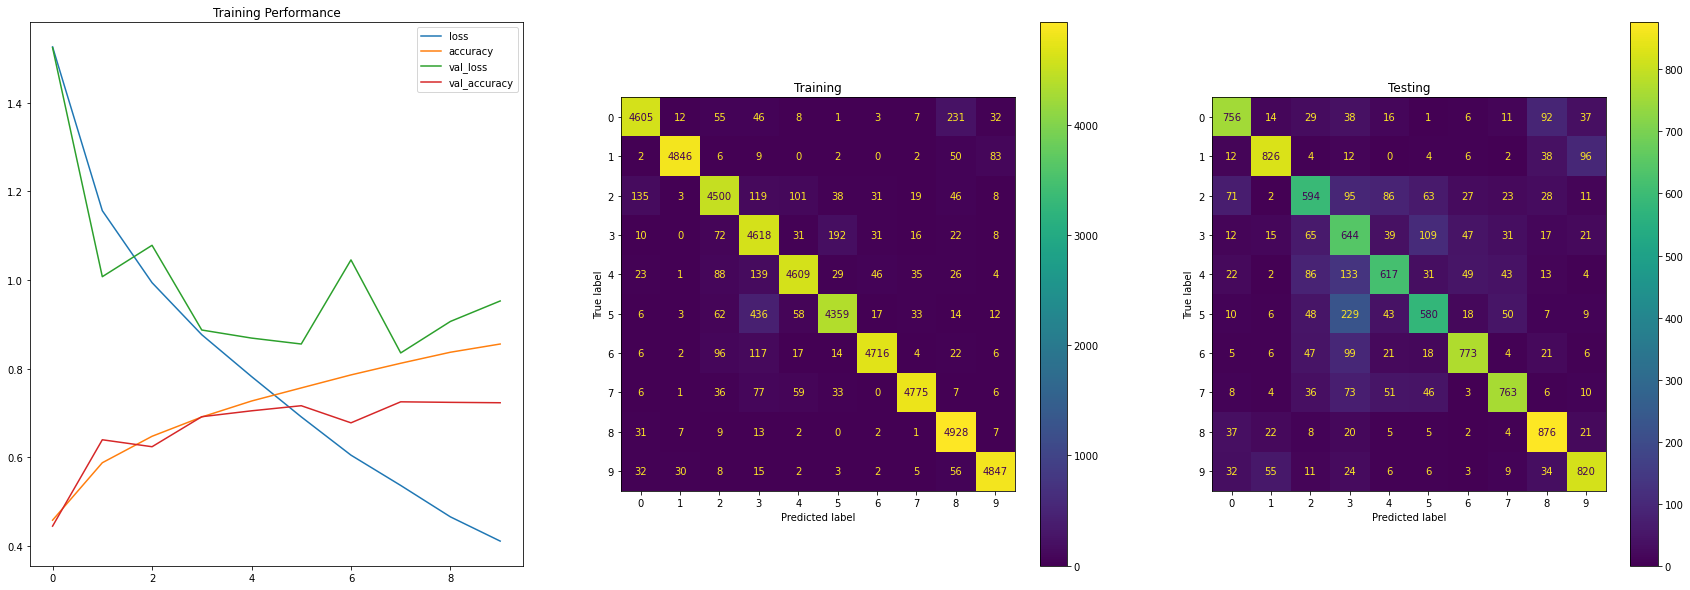

In [17]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_2stage_CIFAR_bigger.h5', batch_size, num_epochs)

### VGG, 3 Stage, Small

Epoch 1/10
390/391 [============================>.] - ETA: 0s - loss: 1.7450 - accuracy: 0.3768
Epoch 00001: val_loss improved from inf to 1.49036, saving model to vgg_3stage_CIFAR_small.h5
391/391 [==============================] - 5s 9ms/step - loss: 1.7449 - accuracy: 0.3769 - val_loss: 1.4904 - val_accuracy: 0.4590
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 1.4153 - accuracy: 0.4907
Epoch 00002: val_loss improved from 1.49036 to 1.23635, saving model to vgg_3stage_CIFAR_small.h5
391/391 [==============================] - 3s 8ms/step - loss: 1.4153 - accuracy: 0.4907 - val_loss: 1.2364 - val_accuracy: 0.5568
Epoch 3/10
385/391 [============================>.] - ETA: 0s - loss: 1.2733 - accuracy: 0.5427
Epoch 00003: val_loss improved from 1.23635 to 1.13327, saving model to vgg_3stage_CIFAR_small.h5
391/391 [==============================] - 3s 8ms/step - loss: 1.2721 - accuracy: 0.5429 - val_loss: 1.1333 - val_accuracy: 0.5962
Epoch 4/10
391/391 [=========

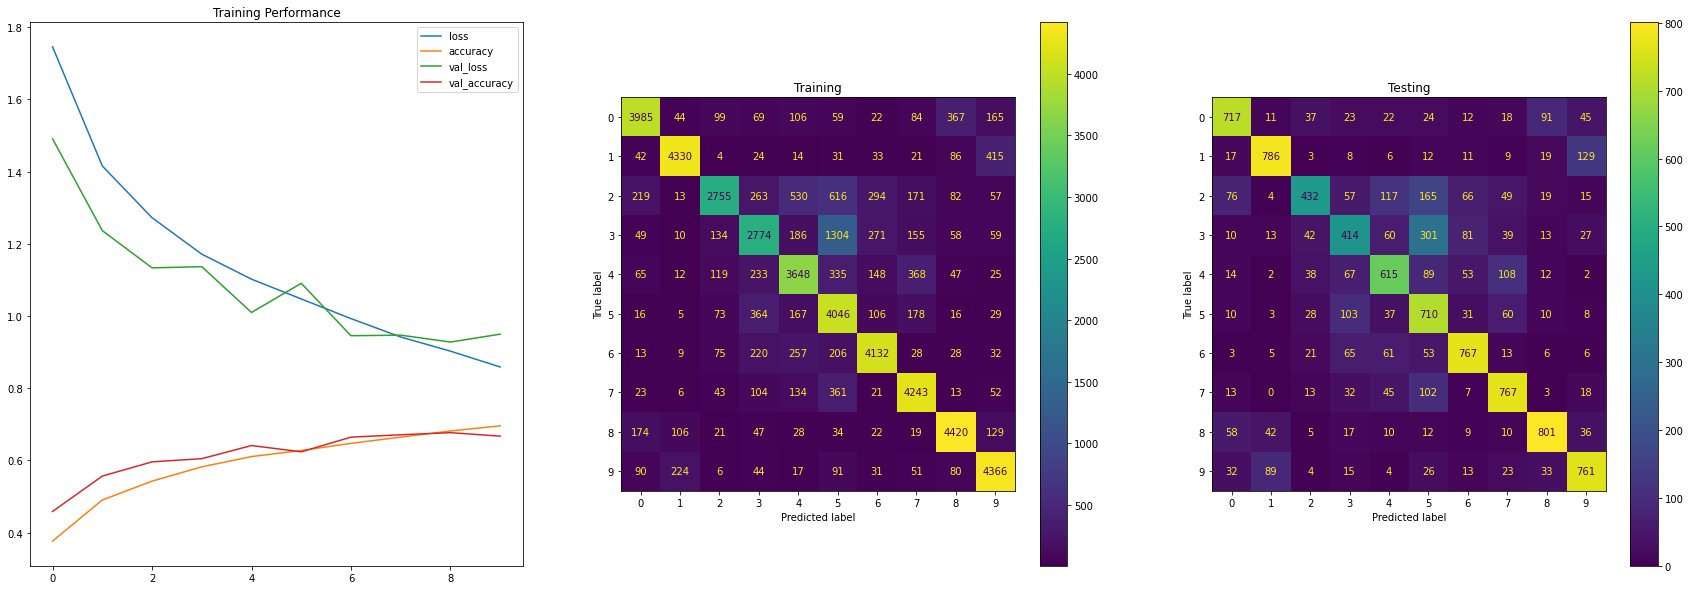

In [18]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [8, 16, 32], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_3stage_CIFAR_small.h5', batch_size, num_epochs)

### VGG, 3 Stage, Bigger

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 1.5842 - accuracy: 0.4343
Epoch 00001: val_loss improved from inf to 1.64895, saving model to vgg_3stage_CIFAR_bigger.h5
391/391 [==============================] - 5s 11ms/step - loss: 1.5842 - accuracy: 0.4343 - val_loss: 1.6490 - val_accuracy: 0.4231
Epoch 2/10
389/391 [============================>.] - ETA: 0s - loss: 1.1606 - accuracy: 0.5869
Epoch 00002: val_loss improved from 1.64895 to 1.03439, saving model to vgg_3stage_CIFAR_bigger.h5
391/391 [==============================] - 5s 12ms/step - loss: 1.1605 - accuracy: 0.5869 - val_loss: 1.0344 - val_accuracy: 0.6342
Epoch 3/10
390/391 [============================>.] - ETA: 0s - loss: 1.0013 - accuracy: 0.6464
Epoch 00003: val_loss improved from 1.03439 to 0.96077, saving model to vgg_3stage_CIFAR_bigger.h5
391/391 [==============================] - 4s 11ms/step - loss: 1.0010 - accuracy: 0.6464 - val_loss: 0.9608 - val_accuracy: 0.6700
Epoch 4/10
390/391 [===

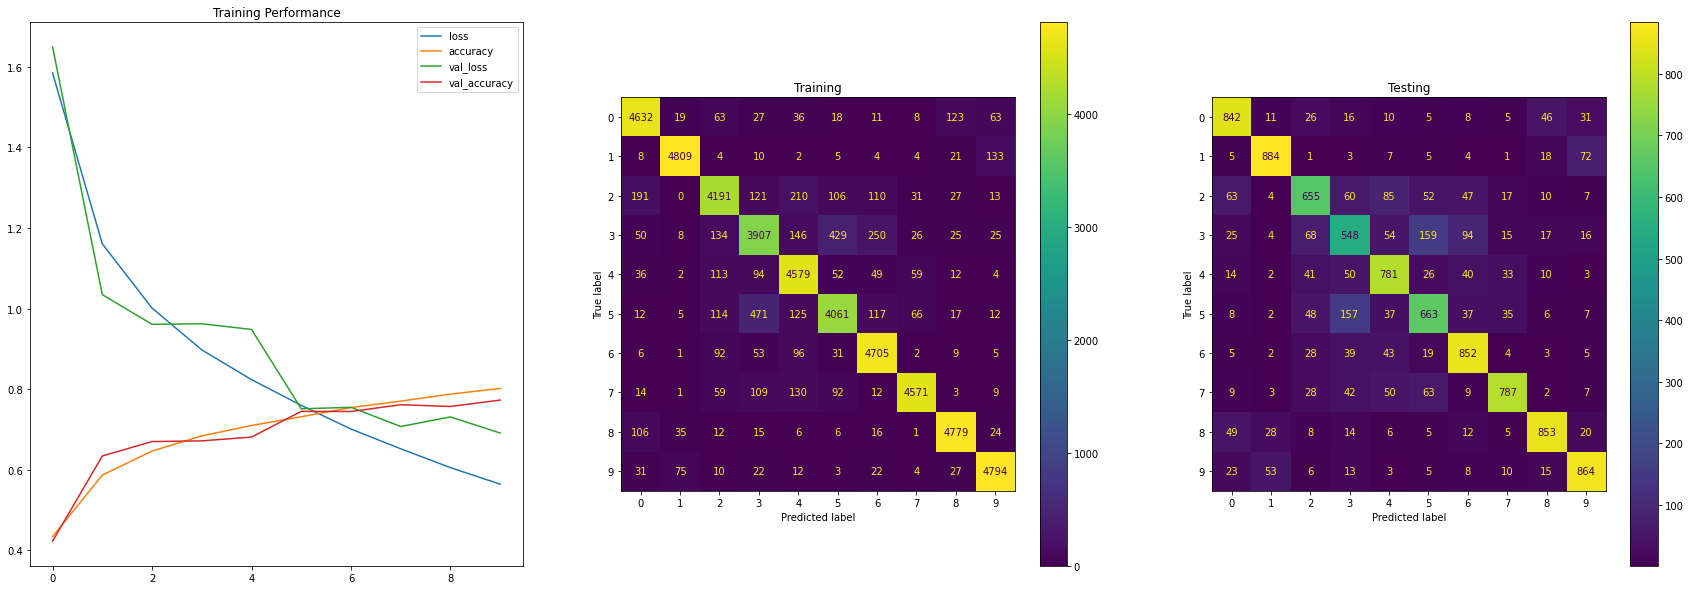

In [19]:
inputs = keras.Input(shape=(32, 32, 3, ), name='img')
x = vgg_net(inputs, [16, 32, 64], [1024, 256], 0.2, 0.2)
output = layers.Dense(10)(x)
model_cnn = keras.Model(inputs=inputs, outputs=output, name='simple_vgg')
model_cnn.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])
train_and_eval(model_cnn, x_train, y_train, x_test, y_test, 'vgg_3stage_CIFAR_bigger.h5', batch_size, num_epochs)

## Final Thoughts
Aa per the ResNet version, this is not really about explanations, but just running stuff. All the same, some thoughts on results follow:
* As we often see, performance is very high on MNIST and Fashion MNIST, and a bit less of CIFAR
* Performance does not drop off in a linear way with complexity. The difference between the smallest/simplest network and the best is not that great
* For the simpler tasks (Fashion MNIST and MNIST) performance is as good as or better than the more complex (and slower) resnet models. This is not the case for CIFAR though. As such, for many small tasks these models are probably sufficient. For ResNet in general, we're not really getting to the depths where we get a big benefit from that. The networks here and the networks in the ResNet example are fairly shallow by current standards. As such the use of skip connections to increase depth is not really needed, and the benefit from this is not observed. 
* Looking at runtimes between this and the ResNet examples, these are much quicker, even for the more complex models

As is often the case in this subject, we're not trying to get the best results possible. These models aren't as complex as they could be, but making them bigger and bigger makes them less and less practical - so we stop before things to get too big and slow.